### Assignment 2: Fitting and Alignment

#### 1. Blob Detection

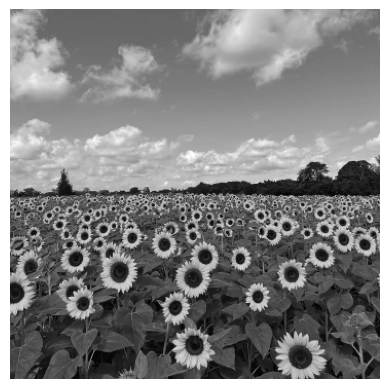

In [34]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

sunflower_image = cv.imread("images/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(sunflower_image, cv.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

Parameters of the largest circle: center=(110, 258), radius=15, sigma=2.0


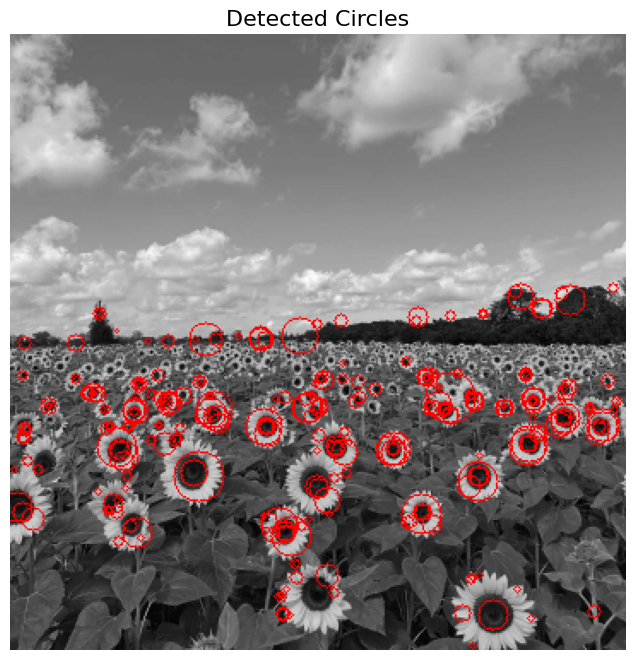

In [41]:
# Set up parameters for scale space blob detection
minimum_sigma = 1.0  # Minimum sigma value (smaller values for smaller blobs)
maximum_sigma = 2.0  # Maximum sigma value (larger values for larger blobs)
n = 4 # Number of sigma values
threshold = 0.35  # Threshold for blob detection

circles = []

# iterate through sigma values to delete overlapping blobs
for sigma in np.linspace(minimum_sigma, maximum_sigma, n):
    # Compute the Laplacian of Gaussian
    image = cv.GaussianBlur(gray_image, (0, 0), sigma)
    image = cv.Laplacian(image, cv.CV_64F)

    # Compute the blob response
    response = np.abs(image) 

    # Find the blobs in the response map
    blob_mask = response > threshold * response.max()

    # find contours in the mask
    contours, _ = cv.findContours(blob_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # iterate through the contours and append the circles to the list
    for contour in contours:
        if cv.contourArea(contour) >= 6:
            ((x, y), r) = cv.minEnclosingCircle(contour)
            c = (int(x), int(y))
            r = int(r)
            circles.append((c, r, sigma))

# sort the detected circles by their radius
circles = sorted(circles, key=lambda x: -x[1])

# parameters of the largst
large_circle = circles[0]
center, radius, sigma = large_circle

print(f"Parameters of the largest circle: center={center}, radius={radius}, sigma={sigma}")

# Convert the grayscale image to a color image for drawing circles
output_image = cv.cvtColor(gray_image, cv.COLOR_GRAY2BGR)

# Draw all detected circles with the specified line thickness
for (center, radius, sigma) in circles:
    cv.circle(output_image, center, radius, (0, 0, 255), 1)  # Red color

# Display the output image with detected circles using matplotlib
plt.figure(figsize=(8, 8))  # Adjusted figure size
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB), cmap='gray')  # Convert to RGB color space
plt.axis('off')  # Hide axes
plt.title('Detected Circles', fontsize=16)  # Slightly larger title font
plt.show()

#### 2. RANSAC

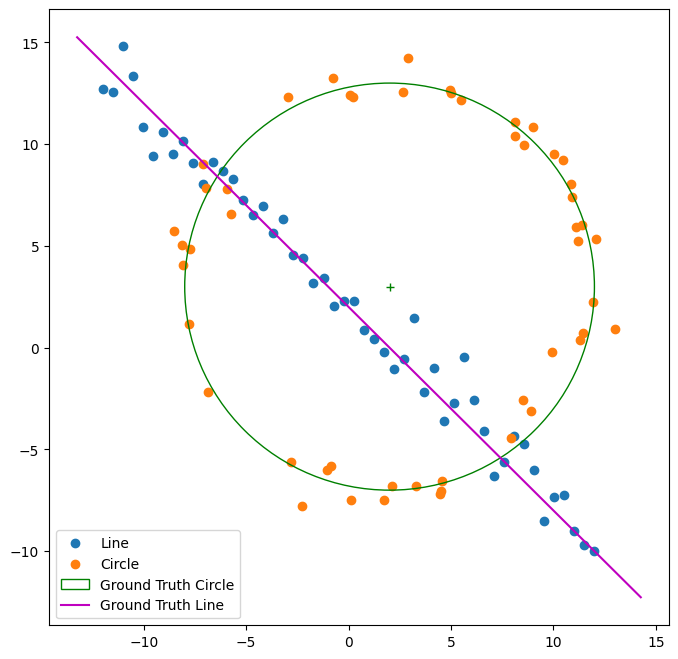

In [59]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import math
import numpy as np

# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)

# Circle points
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Line points
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine circle and line points
X = np.vstack((X_circ, X_line))

# Plot the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Plot the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='g')

# Plot the ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground Truth Line')

plt.legend()
plt.show()


In [109]:
import numpy as np

# Define a function to compute the equation of a straight line from two points
def compute_line_eq(x0, y0, x1, y1):
    # a, b, d where [a,b]⊺ is the unit normal to the line and d is the perpendicular distance from the origin
    delta_x = x1 - x0
    delta_y = y1 - y0
    line_norm = np.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / line_norm
    b = -delta_x / line_norm
    d = a * x0 + b * y0
    return a, b, d

# Define a function to calculate the circle equation from three points
def compute_circle_eq(x0, y0, x1, y1, x2, y2):
    mid_x0, mid_y0 = (x0 + x1) / 2, (y0 + y1) / 2
    mid_x1, mid_y1 = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Compute slopes
    slope0 = (x1 - x0) / (y1 - y0) if (y1 - y0) != 0 else 0
    slope1 = (x2 - x1) / (y2 - y1) if (y2 - y1) != 0 else 0
    
    # Calculate the center of the circle
    x_center = (slope0 * mid_x0 - slope1 * mid_x1 + mid_y1 - mid_y0) / (slope0 - slope1)
    y_center = -slope0 * (x_center - mid_x0) + mid_y0
    
    # Calculate the radius
    radius = np.sqrt((x0 - x_center) ** 2 + (y0 - y_center) ** 2)
    
    return x_center, y_center, radius

# RANSAC function for fitting a line
def ransac_line_fit(points, num_iter, dist_threshold, min_inliers):
    optimal_model = None
    max_inliers = []

    for _ in range(num_iter):
        indices = np.random.choice(len(points), 2, replace=False)
        x0, y0 = points[indices[0]]
        x1, y1 = points[indices[1]]
        
        a, b, d = compute_line_eq(x0, y0, x1, y1)
        
        # Constraint: Ensure unit normal vector
        normal_mag = np.sqrt(a**2 + b**2)
        a /= normal_mag
        b /= normal_mag
        
        # Compute the distance of each point to the line
        dists = np.abs(a * points[:, 0] + b * points[:, 1] - d)
        
        # Identify inliers based on distance threshold
        inliers = np.where(dists < dist_threshold)[0]
        
        if len(inliers) >= min_inliers and len(inliers) > len(max_inliers):
            optimal_model = (a, b, d)
            max_inliers = inliers

    return optimal_model, max_inliers


# RANSAC function for fitting a circle
def ransac_circle_fit(points, num_iter, dist_threshold, min_inliers):
    optimal_circle = None
    max_inliers = []
    
    for _ in range(num_iter):
        indices = np.random.choice(len(points), 3, replace=False)
        x0, y0 = points[indices[0]]
        x1, y1 = points[indices[1]]
        x2, y2 = points[indices[2]]
        
        x_center, y_center, radius = compute_circle_eq(x0, y0, x1, y1, x2, y2)
        
        # Calculate radial error for all points
        errors = np.abs(np.sqrt((points[:, 0] - x_center)**2 + (points[:, 1] - y_center)**2) - radius)
        
        # Identify inliers based on distance threshold
        inliers = np.where(errors < dist_threshold)[0]
        
        if len(inliers) >= min_inliers and len(inliers) > len(max_inliers):
            optimal_circle = (x_center, y_center, radius)
            max_inliers = inliers

    return optimal_circle, max_inliers

# RANSAC parameters for line fitting
line_iterations = 10000
line_threshold = 0.15
line_min_inliers = 15

# Estimate line model using RANSAC
best_line_models, line_inliers = ransac_line_fit(X, line_iterations, line_threshold, line_min_inliers)

# Check and display the results of line fitting
if best_line_models is not None:
    print(f"Line inliers count: {len(line_inliers)}")
    print(f"Estimated line parameters: a={best_line_models[0]}, b={best_line_models[1]}, d={best_line_models[2]}")
else:
    print("Line model could not be estimated. Adjust iterations or threshold.")

# RANSAC parameters for circle fitting
circle_iterations = 10000
circle_threshold = 0.2
circle_min_inliers = 15

# Identify remaining points that are not part of the line
remaining_indices = [i for i in range(len(X)) if i not in line_inliers]
remaining_points = X[remaining_indices]

print(f"Remaining points count: {len(remaining_points)}")

# Estimate circle model using RANSAC
best_circle_models, circle_inliers = ransac_circle_fit(remaining_points, circle_iterations, circle_threshold, circle_min_inliers)

# Display the results of circle fitting
if best_circle_models is not None:
    print(f"Circle inliers count: {len(circle_inliers)}")
    print(f"Estimated circle parameters: center=({best_circle_models[0]}, {best_circle_models[1]}), radius={best_circle_models[2]}")
else:
    print("Circle model could not be estimated.")


Line inliers count: 15
Estimated line parameters: a=0.7062747654621846, b=0.7079378190712347, d=1.397493405581553
Remaining points count: 85
Circle inliers count: 18
Estimated circle parameters: center=(1.8653544029954272, 3.6204019634493445), radius=10.012492942609567


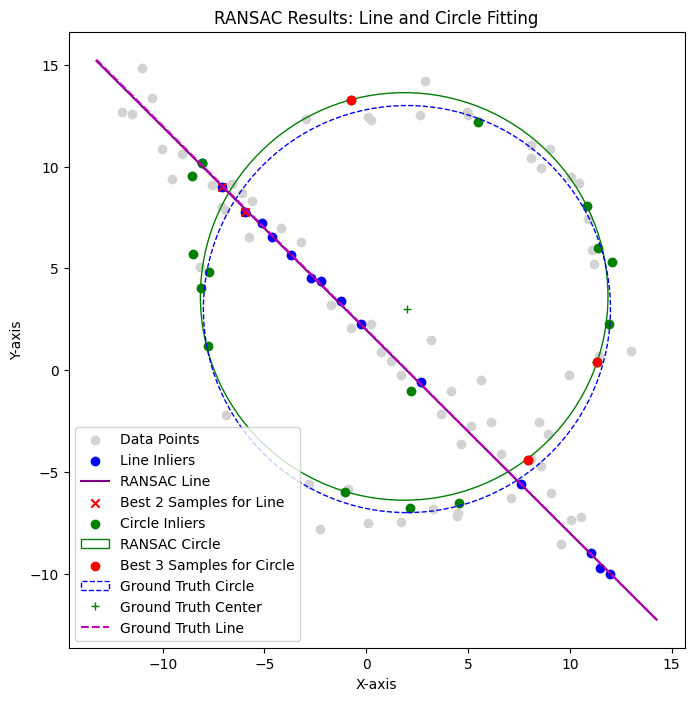

In [110]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot original points from the full dataset X
ax.scatter(X[:, 0], X[:, 1], color='lightgray', label='Data Points')

# Plot the inliers for the line
if best_line_models is not None:
    ax.scatter(X[line_inliers, 0], X[line_inliers, 1], color='blue', label='Line Inliers')

    # Plot the estimated line
    x_min, x_max = ax.get_xlim()
    x_range = np.array([x_min, x_max])
    y_range = (-best_line_models[0] * x_range + best_line_models[2]) / best_line_models[1]
    plt.plot(x_range, y_range, label='RANSAC Line', color='purple')

    # Mark the best 2 samples for the line
    best_line_sample_indices = line_inliers[:2]
    best_line_samples = X[best_line_sample_indices]
    ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
else:
    print("No valid line model found.")

# Plot the inliers for the circle
if best_circle_models is not None:
    ax.scatter(X[circle_inliers, 0], X[circle_inliers, 1], color='green', label='Circle Inliers')

    # Plot the estimated circle
    x_center, y_center, radius = best_circle_models
    circle_estimated = plt.Circle((x_center, y_center), radius, color='green', fill=False, label='RANSAC Circle')
    ax.add_artist(circle_estimated)

    # Mark the best 3 samples for the circle
    best_circle_sample_indices = circle_inliers[:3]
    best_circle_samples = X[best_circle_sample_indices]
    ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')
else:
    print("No valid circle model found.")

# Add the ground truth circle and line (for comparison)
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, linestyle='--', label='Ground Truth Circle')
ax.add_artist(circle_gt)

ax.plot(x0_gt, y0_gt, '+g', label='Ground Truth Center')

y_range_gt = m * x_range + b
plt.plot(x_range, y_range_gt, color='m', linestyle='--', label='Ground Truth Line')

# Set plot properties
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_aspect('equal')
plt.legend()
plt.title('RANSAC Results: Line and Circle Fitting')
plt.show()


In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_image = cv2.imread('images/building.jpg')
flag_image = cv2.imread('images/flag.png')

# Display the architectural image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(architectural_image, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, architectural_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, architectural_image.shape[0], 20))
plt.grid(True, color='white', linewidth=1)
plt.title('Architectural Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the architectural image that form a planar surface
# Replace these with the actual coordinates
points_on_architecture = np.array([[120, 230], [540, 315], [540, 545], [90, 540]], dtype=np.float32)

# Define the corresponding points on the flag image (in the same order)
points_on_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_flag, points_on_architecture)

# Warp the flag image onto the architectural image using the homography
flag_warped = cv2.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the warped flag image with the architectural image
result_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


<Figure size 1000x1000 with 0 Axes>